<h1> Homework 4 </h1>

<h2> Problem 1: Transfer learning: Shallow learning vs Finetuning, Pytorch </h2>

<p> 1. Credit: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
(a) </p>

In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/dtd'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

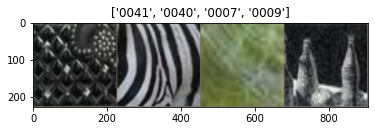

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

This dataset has 47 classes, the dimension of each image is 3x224x224, and there has 10 samples in each class.

<p> (b) </p>

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return modelmodel_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 47)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

In [21]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 47)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/yl8251/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 3.7843 Acc: 0.0548
val Loss: 3.6209 Acc: 0.1282

Epoch 1/199
----------
train Loss: 3.4648 Acc: 0.2064
val Loss: 3.2603 Acc: 0.2654

Epoch 2/199
----------
train Loss: 3.0836 Acc: 0.3048
val Loss: 2.9055 Acc: 0.3229

Epoch 3/199
----------
train Loss: 2.7490 Acc: 0.3649
val Loss: 2.6445 Acc: 0.3537

Epoch 4/199
----------
train Loss: 2.4757 Acc: 0.4064
val Loss: 2.4193 Acc: 0.3894

Epoch 5/199
----------
train Loss: 2.2308 Acc: 0.4553
val Loss: 2.2753 Acc: 0.4090

Epoch 6/199
----------
train Loss: 2.0330 Acc: 0.5005
val Loss: 2.1586 Acc: 0.4255

Epoch 7/199
----------
train Loss: 1.8955 Acc: 0.5101
val Loss: 2.0585 Acc: 0.4516

Epoch 8/199
----------
train Loss: 1.7869 Acc: 0.5351
val Loss: 2.0055 Acc: 0.4495

Epoch 9/199
----------
train Loss: 1.6752 Acc: 0.5638
val Loss: 1.9476 Acc: 0.4638

Epoch 10/199
----------
train Loss: 1.5286 Acc: 0.5941
val Loss: 1.9149 Acc: 0.4691

Epoch 11/199
----------
train Loss: 1.4692 Acc: 0.6096
val Loss: 1.8834 Acc

val Loss: 2.0476 Acc: 0.5298

Epoch 97/199
----------
train Loss: 0.1510 Acc: 0.9633
val Loss: 2.0591 Acc: 0.5277

Epoch 98/199
----------
train Loss: 0.1426 Acc: 0.9670
val Loss: 2.0472 Acc: 0.5303

Epoch 99/199
----------
train Loss: 0.1547 Acc: 0.9654
val Loss: 2.0520 Acc: 0.5314

Epoch 100/199
----------
train Loss: 0.1438 Acc: 0.9707
val Loss: 2.0485 Acc: 0.5335

Epoch 101/199
----------
train Loss: 0.1314 Acc: 0.9729
val Loss: 2.0441 Acc: 0.5330

Epoch 102/199
----------
train Loss: 0.1365 Acc: 0.9697
val Loss: 2.0472 Acc: 0.5287

Epoch 103/199
----------
train Loss: 0.1464 Acc: 0.9686
val Loss: 2.0573 Acc: 0.5282

Epoch 104/199
----------
train Loss: 0.1514 Acc: 0.9676
val Loss: 2.0593 Acc: 0.5309

Epoch 105/199
----------
train Loss: 0.1412 Acc: 0.9676
val Loss: 2.0539 Acc: 0.5293

Epoch 106/199
----------
train Loss: 0.1379 Acc: 0.9739
val Loss: 2.0513 Acc: 0.5309

Epoch 107/199
----------
train Loss: 0.1432 Acc: 0.9686
val Loss: 2.0386 Acc: 0.5335

Epoch 108/199
----------
tr

train Loss: 0.1386 Acc: 0.9686
val Loss: 2.0538 Acc: 0.5346

Epoch 193/199
----------
train Loss: 0.1319 Acc: 0.9713
val Loss: 2.0495 Acc: 0.5287

Epoch 194/199
----------
train Loss: 0.1276 Acc: 0.9723
val Loss: 2.0514 Acc: 0.5319

Epoch 195/199
----------
train Loss: 0.1468 Acc: 0.9676
val Loss: 2.0457 Acc: 0.5271

Epoch 196/199
----------
train Loss: 0.1402 Acc: 0.9686
val Loss: 2.0551 Acc: 0.5303

Epoch 197/199
----------
train Loss: 0.1292 Acc: 0.9686
val Loss: 2.0518 Acc: 0.5282

Epoch 198/199
----------
train Loss: 0.1418 Acc: 0.9686
val Loss: 2.0475 Acc: 0.5346

Epoch 199/199
----------
train Loss: 0.1438 Acc: 0.9660
val Loss: 2.0363 Acc: 0.5330

Training complete in 36m 59s
Best val Acc: 0.539362


<p> (c) </p>

In [23]:
# learning rate is 0.01
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 47)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 3.4008 Acc: 0.1564
val Loss: 2.8401 Acc: 0.2739

Epoch 1/199
----------
train Loss: 2.4348 Acc: 0.3505
val Loss: 2.8671 Acc: 0.2867

Epoch 2/199
----------
train Loss: 2.1529 Acc: 0.4213
val Loss: 2.6579 Acc: 0.3463

Epoch 3/199
----------
train Loss: 1.9304 Acc: 0.4537
val Loss: 2.8233 Acc: 0.3484

Epoch 4/199
----------
train Loss: 1.6601 Acc: 0.5197
val Loss: 2.5713 Acc: 0.3995

Epoch 5/199
----------
train Loss: 1.4382 Acc: 0.5878
val Loss: 2.5121 Acc: 0.3894

Epoch 6/199
----------
train Loss: 1.3334 Acc: 0.6112
val Loss: 2.7287 Acc: 0.3894

Epoch 7/199
----------
train Loss: 1.2583 Acc: 0.6186
val Loss: 2.6230 Acc: 0.4176

Epoch 8/199
----------
train Loss: 1.1271 Acc: 0.6516
val Loss: 2.9279 Acc: 0.3814

Epoch 9/199
----------
train Loss: 0.9287 Acc: 0.7101
val Loss: 2.5988 Acc: 0.4404

Epoch 10/199
----------
train Loss: 0.8746 Acc: 0.7346
val Loss: 2.7512 Acc: 0.4255

Epoch 11/199
----------
train Loss: 0.8367 Acc: 0.7564
val Loss: 2.8051 Acc

val Loss: 3.1377 Acc: 0.4830

Epoch 97/199
----------
train Loss: 0.0600 Acc: 0.9814
val Loss: 3.1508 Acc: 0.4830

Epoch 98/199
----------
train Loss: 0.0526 Acc: 0.9846
val Loss: 3.1619 Acc: 0.4862

Epoch 99/199
----------
train Loss: 0.0510 Acc: 0.9835
val Loss: 3.1676 Acc: 0.4872

Epoch 100/199
----------
train Loss: 0.0522 Acc: 0.9846
val Loss: 3.1623 Acc: 0.4819

Epoch 101/199
----------
train Loss: 0.0549 Acc: 0.9872
val Loss: 3.1725 Acc: 0.4840

Epoch 102/199
----------
train Loss: 0.0555 Acc: 0.9819
val Loss: 3.1863 Acc: 0.4846

Epoch 103/199
----------
train Loss: 0.0464 Acc: 0.9856
val Loss: 3.1831 Acc: 0.4846

Epoch 104/199
----------
train Loss: 0.0503 Acc: 0.9883
val Loss: 3.1660 Acc: 0.4851

Epoch 105/199
----------
train Loss: 0.0529 Acc: 0.9846
val Loss: 3.1615 Acc: 0.4824

Epoch 106/199
----------
train Loss: 0.0446 Acc: 0.9878
val Loss: 3.1910 Acc: 0.4862

Epoch 107/199
----------
train Loss: 0.0390 Acc: 0.9883
val Loss: 3.1808 Acc: 0.4798

Epoch 108/199
----------
tr

train Loss: 0.0329 Acc: 0.9915
val Loss: 3.1585 Acc: 0.4803

Epoch 193/199
----------
train Loss: 0.0429 Acc: 0.9862
val Loss: 3.1882 Acc: 0.4819

Epoch 194/199
----------
train Loss: 0.0314 Acc: 0.9920
val Loss: 3.1434 Acc: 0.4809

Epoch 195/199
----------
train Loss: 0.0427 Acc: 0.9894
val Loss: 3.1426 Acc: 0.4840

Epoch 196/199
----------
train Loss: 0.0533 Acc: 0.9878
val Loss: 3.1406 Acc: 0.4824

Epoch 197/199
----------
train Loss: 0.0485 Acc: 0.9878
val Loss: 3.1294 Acc: 0.4814

Epoch 198/199
----------
train Loss: 0.0433 Acc: 0.9878
val Loss: 3.1344 Acc: 0.4824

Epoch 199/199
----------
train Loss: 0.0377 Acc: 0.9904
val Loss: 3.1322 Acc: 0.4830

Training complete in 36m 59s
Best val Acc: 0.489894


In [24]:
# learning rate is 0.1
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 47)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 4.8588 Acc: 0.0356
val Loss: 611.6956 Acc: 0.0213

Epoch 1/199
----------
train Loss: 3.9414 Acc: 0.0261
val Loss: 51.2117 Acc: 0.0255

Epoch 2/199
----------
train Loss: 3.8421 Acc: 0.0356
val Loss: 3.9511 Acc: 0.0383

Epoch 3/199
----------
train Loss: 3.7856 Acc: 0.0447
val Loss: 3.7989 Acc: 0.0420

Epoch 4/199
----------
train Loss: 3.7515 Acc: 0.0415
val Loss: 3.7798 Acc: 0.0473

Epoch 5/199
----------
train Loss: 3.7293 Acc: 0.0511
val Loss: 3.8028 Acc: 0.0521

Epoch 6/199
----------
train Loss: 3.7008 Acc: 0.0532
val Loss: 3.7522 Acc: 0.0644

Epoch 7/199
----------
train Loss: 3.6605 Acc: 0.0681
val Loss: 3.7531 Acc: 0.0596

Epoch 8/199
----------
train Loss: 3.6631 Acc: 0.0676
val Loss: 3.8108 Acc: 0.0638

Epoch 9/199
----------
train Loss: 3.6297 Acc: 0.0771
val Loss: 3.7402 Acc: 0.0745

Epoch 10/199
----------
train Loss: 3.6286 Acc: 0.0793
val Loss: 3.6711 Acc: 0.0782

Epoch 11/199
----------
train Loss: 3.6273 Acc: 0.0835
val Loss: 3.7200 

val Loss: 4.7512 Acc: 0.1915

Epoch 97/199
----------
train Loss: 1.0251 Acc: 0.6904
val Loss: 4.7831 Acc: 0.1968

Epoch 98/199
----------
train Loss: 0.9920 Acc: 0.6936
val Loss: 4.7210 Acc: 0.2160

Epoch 99/199
----------
train Loss: 0.9780 Acc: 0.7064
val Loss: 4.8487 Acc: 0.1995

Epoch 100/199
----------
train Loss: 1.0198 Acc: 0.6910
val Loss: 4.8281 Acc: 0.2043

Epoch 101/199
----------
train Loss: 0.9910 Acc: 0.6995
val Loss: 4.7545 Acc: 0.2037

Epoch 102/199
----------
train Loss: 0.9839 Acc: 0.6878
val Loss: 4.9157 Acc: 0.2064

Epoch 103/199
----------
train Loss: 0.9443 Acc: 0.7138
val Loss: 4.9103 Acc: 0.2059

Epoch 104/199
----------
train Loss: 0.9614 Acc: 0.7202
val Loss: 4.8855 Acc: 0.2112

Epoch 105/199
----------
train Loss: 0.9196 Acc: 0.7197
val Loss: 4.8992 Acc: 0.2048

Epoch 106/199
----------
train Loss: 0.9323 Acc: 0.7106
val Loss: 4.9483 Acc: 0.1968

Epoch 107/199
----------
train Loss: 0.8432 Acc: 0.7585
val Loss: 4.9551 Acc: 0.2154

Epoch 108/199
----------
tr

train Loss: 0.3266 Acc: 0.9165
val Loss: 5.5885 Acc: 0.2128

Epoch 193/199
----------
train Loss: 0.3605 Acc: 0.9048
val Loss: 5.5179 Acc: 0.2122

Epoch 194/199
----------
train Loss: 0.3220 Acc: 0.9181
val Loss: 5.5345 Acc: 0.2133

Epoch 195/199
----------
train Loss: 0.3260 Acc: 0.9160
val Loss: 5.5158 Acc: 0.2176

Epoch 196/199
----------
train Loss: 0.3277 Acc: 0.9165
val Loss: 5.5140 Acc: 0.2181

Epoch 197/199
----------
train Loss: 0.3192 Acc: 0.9165
val Loss: 5.5116 Acc: 0.2298

Epoch 198/199
----------
train Loss: 0.3206 Acc: 0.9154
val Loss: 5.5540 Acc: 0.2160

Epoch 199/199
----------
train Loss: 0.3413 Acc: 0.9037
val Loss: 5.5841 Acc: 0.2186

Training complete in 36m 50s
Best val Acc: 0.229787


<p> The accuracy of learning rate 0.001 is 53.94%, while the accuracy of learing rate 0.01 is 48.99% and the accuracy of learning rate 0.1 is 22.98%. So learing rate 0.001 has the best accuracy on the target dataset </p>

<p> 2. (a) </p>

In [4]:
for learning_rate in [1, 0.1, 0.01, 0.001]:
    print('learning rate is ' + str(learning_rate))

    model_ft = models.resnet50(pretrained=True)

    for param in model_ft.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 47)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=60, gamma=0.1)

    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                          num_epochs=200)

learning rate is 1
Epoch 0/199
----------
train Loss: 340.7392 Acc: 0.0952
val Loss: 420.3039 Acc: 0.1559

Epoch 1/199
----------
train Loss: 224.0228 Acc: 0.2133
val Loss: 115.0700 Acc: 0.2617

Epoch 2/199
----------
train Loss: 99.1738 Acc: 0.2755
val Loss: 81.5486 Acc: 0.3293

Epoch 3/199
----------
train Loss: 77.0386 Acc: 0.3511
val Loss: 76.6851 Acc: 0.3255

Epoch 4/199
----------
train Loss: 56.5768 Acc: 0.3862
val Loss: 70.4648 Acc: 0.3255

Epoch 5/199
----------
train Loss: 62.0441 Acc: 0.3707
val Loss: 73.6017 Acc: 0.3457

Epoch 6/199
----------
train Loss: 54.8730 Acc: 0.4090
val Loss: 93.8556 Acc: 0.3011

Epoch 7/199
----------
train Loss: 55.7491 Acc: 0.4112
val Loss: 64.4834 Acc: 0.3431

Epoch 8/199
----------
train Loss: 52.6060 Acc: 0.4170
val Loss: 70.6583 Acc: 0.3670

Epoch 9/199
----------
train Loss: 53.1689 Acc: 0.4154
val Loss: 77.3585 Acc: 0.3468

Epoch 10/199
----------
train Loss: 56.8403 Acc: 0.4277
val Loss: 76.3188 Acc: 0.3447

Epoch 11/199
----------
train 

train Loss: 13.8176 Acc: 0.7271
val Loss: 57.4076 Acc: 0.4399

Epoch 95/199
----------
train Loss: 13.6623 Acc: 0.7298
val Loss: 56.2534 Acc: 0.4420

Epoch 96/199
----------
train Loss: 12.7617 Acc: 0.7596
val Loss: 55.8704 Acc: 0.4431

Epoch 97/199
----------
train Loss: 12.3292 Acc: 0.7484
val Loss: 55.9372 Acc: 0.4447

Epoch 98/199
----------
train Loss: 12.2765 Acc: 0.7564
val Loss: 56.7333 Acc: 0.4367

Epoch 99/199
----------
train Loss: 12.0703 Acc: 0.7612
val Loss: 56.5741 Acc: 0.4399

Epoch 100/199
----------
train Loss: 13.1899 Acc: 0.7372
val Loss: 55.6003 Acc: 0.4426

Epoch 101/199
----------
train Loss: 12.6481 Acc: 0.7436
val Loss: 56.2483 Acc: 0.4452

Epoch 102/199
----------
train Loss: 11.7827 Acc: 0.7612
val Loss: 56.1915 Acc: 0.4548

Epoch 103/199
----------
train Loss: 11.2165 Acc: 0.7628
val Loss: 55.8617 Acc: 0.4447

Epoch 104/199
----------
train Loss: 12.9621 Acc: 0.7426
val Loss: 54.5048 Acc: 0.4516

Epoch 105/199
----------
train Loss: 11.3546 Acc: 0.7590
val L

train Loss: 10.1043 Acc: 0.7739
val Loss: 52.1515 Acc: 0.4473

Epoch 189/199
----------
train Loss: 10.2561 Acc: 0.7750
val Loss: 52.1442 Acc: 0.4500

Epoch 190/199
----------
train Loss: 10.0651 Acc: 0.7803
val Loss: 51.9375 Acc: 0.4527

Epoch 191/199
----------
train Loss: 9.4664 Acc: 0.7835
val Loss: 51.7317 Acc: 0.4521

Epoch 192/199
----------
train Loss: 10.4145 Acc: 0.7686
val Loss: 52.0618 Acc: 0.4505

Epoch 193/199
----------
train Loss: 10.4005 Acc: 0.7734
val Loss: 52.0361 Acc: 0.4527

Epoch 194/199
----------
train Loss: 10.4602 Acc: 0.7665
val Loss: 52.2090 Acc: 0.4527

Epoch 195/199
----------
train Loss: 9.8472 Acc: 0.7745
val Loss: 51.5717 Acc: 0.4495

Epoch 196/199
----------
train Loss: 9.9125 Acc: 0.7739
val Loss: 52.3169 Acc: 0.4447

Epoch 197/199
----------
train Loss: 10.4053 Acc: 0.7628
val Loss: 52.2290 Acc: 0.4468

Epoch 198/199
----------
train Loss: 9.1714 Acc: 0.7766
val Loss: 52.0942 Acc: 0.4537

Epoch 199/199
----------
train Loss: 9.4866 Acc: 0.7809
val L

val Loss: 5.4442 Acc: 0.4479

Epoch 84/199
----------
train Loss: 1.4819 Acc: 0.7330
val Loss: 5.4175 Acc: 0.4473

Epoch 85/199
----------
train Loss: 1.2491 Acc: 0.7511
val Loss: 5.4406 Acc: 0.4468

Epoch 86/199
----------
train Loss: 1.4509 Acc: 0.7213
val Loss: 5.4880 Acc: 0.4404

Epoch 87/199
----------
train Loss: 1.2814 Acc: 0.7537
val Loss: 5.3600 Acc: 0.4378

Epoch 88/199
----------
train Loss: 1.2699 Acc: 0.7521
val Loss: 5.2741 Acc: 0.4473

Epoch 89/199
----------
train Loss: 1.1372 Acc: 0.7809
val Loss: 5.3888 Acc: 0.4356

Epoch 90/199
----------
train Loss: 1.1313 Acc: 0.7628
val Loss: 5.3208 Acc: 0.4452

Epoch 91/199
----------
train Loss: 1.2311 Acc: 0.7553
val Loss: 5.3603 Acc: 0.4473

Epoch 92/199
----------
train Loss: 1.2835 Acc: 0.7516
val Loss: 5.2949 Acc: 0.4457

Epoch 93/199
----------
train Loss: 1.2200 Acc: 0.7660
val Loss: 5.2829 Acc: 0.4495

Epoch 94/199
----------
train Loss: 1.1148 Acc: 0.7755
val Loss: 5.2986 Acc: 0.4404

Epoch 95/199
----------
train Loss:

train Loss: 0.8782 Acc: 0.7936
val Loss: 4.9106 Acc: 0.4606

Epoch 180/199
----------
train Loss: 1.0388 Acc: 0.7819
val Loss: 4.8979 Acc: 0.4532

Epoch 181/199
----------
train Loss: 0.9717 Acc: 0.7830
val Loss: 4.9586 Acc: 0.4457

Epoch 182/199
----------
train Loss: 0.9114 Acc: 0.8011
val Loss: 4.8928 Acc: 0.4543

Epoch 183/199
----------
train Loss: 1.0527 Acc: 0.7750
val Loss: 4.8835 Acc: 0.4532

Epoch 184/199
----------
train Loss: 1.1031 Acc: 0.7745
val Loss: 4.8908 Acc: 0.4559

Epoch 185/199
----------
train Loss: 1.0339 Acc: 0.7814
val Loss: 4.8824 Acc: 0.4500

Epoch 186/199
----------
train Loss: 0.9440 Acc: 0.7894
val Loss: 4.8802 Acc: 0.4559

Epoch 187/199
----------
train Loss: 0.9129 Acc: 0.7878
val Loss: 4.9332 Acc: 0.4553

Epoch 188/199
----------
train Loss: 0.9362 Acc: 0.7819
val Loss: 4.9113 Acc: 0.4564

Epoch 189/199
----------
train Loss: 0.9723 Acc: 0.7782
val Loss: 4.9427 Acc: 0.4553

Epoch 190/199
----------
train Loss: 0.9454 Acc: 0.7883
val Loss: 4.8926 Acc: 0

train Loss: 1.0996 Acc: 0.6840
val Loss: 2.0882 Acc: 0.4633

Epoch 76/199
----------
train Loss: 1.0583 Acc: 0.6973
val Loss: 2.0906 Acc: 0.4686

Epoch 77/199
----------
train Loss: 1.0929 Acc: 0.6888
val Loss: 2.0845 Acc: 0.4707

Epoch 78/199
----------
train Loss: 1.0769 Acc: 0.6941
val Loss: 2.0875 Acc: 0.4665

Epoch 79/199
----------
train Loss: 1.0398 Acc: 0.7101
val Loss: 2.0948 Acc: 0.4649

Epoch 80/199
----------
train Loss: 1.0460 Acc: 0.6989
val Loss: 2.0867 Acc: 0.4691

Epoch 81/199
----------
train Loss: 1.0124 Acc: 0.7282
val Loss: 2.0802 Acc: 0.4649

Epoch 82/199
----------
train Loss: 1.1074 Acc: 0.6830
val Loss: 2.0952 Acc: 0.4601

Epoch 83/199
----------
train Loss: 1.0752 Acc: 0.6915
val Loss: 2.0867 Acc: 0.4644

Epoch 84/199
----------
train Loss: 1.0767 Acc: 0.6952
val Loss: 2.1069 Acc: 0.4660

Epoch 85/199
----------
train Loss: 1.0456 Acc: 0.6910
val Loss: 2.0843 Acc: 0.4681

Epoch 86/199
----------
train Loss: 1.0567 Acc: 0.7122
val Loss: 2.0971 Acc: 0.4660

Epoc

train Loss: 1.0330 Acc: 0.7016
val Loss: 2.0840 Acc: 0.4686

Epoch 172/199
----------
train Loss: 1.0654 Acc: 0.7027
val Loss: 2.0870 Acc: 0.4681

Epoch 173/199
----------
train Loss: 1.0049 Acc: 0.7144
val Loss: 2.0962 Acc: 0.4649

Epoch 174/199
----------
train Loss: 1.0238 Acc: 0.7197
val Loss: 2.0807 Acc: 0.4665

Epoch 175/199
----------
train Loss: 1.0491 Acc: 0.7149
val Loss: 2.1029 Acc: 0.4606

Epoch 176/199
----------
train Loss: 1.0557 Acc: 0.7069
val Loss: 2.1010 Acc: 0.4638

Epoch 177/199
----------
train Loss: 1.0190 Acc: 0.7133
val Loss: 2.0895 Acc: 0.4654

Epoch 178/199
----------
train Loss: 1.0288 Acc: 0.7122
val Loss: 2.1000 Acc: 0.4670

Epoch 179/199
----------
train Loss: 0.9968 Acc: 0.7149
val Loss: 2.0916 Acc: 0.4665

Epoch 180/199
----------
train Loss: 1.0270 Acc: 0.7106
val Loss: 2.0865 Acc: 0.4638

Epoch 181/199
----------
train Loss: 1.0192 Acc: 0.7165
val Loss: 2.0814 Acc: 0.4691

Epoch 182/199
----------
train Loss: 1.0324 Acc: 0.7032
val Loss: 2.0950 Acc: 0

val Loss: 2.0097 Acc: 0.4628

Epoch 67/199
----------
train Loss: 1.7271 Acc: 0.5479
val Loss: 2.0159 Acc: 0.4617

Epoch 68/199
----------
train Loss: 1.7567 Acc: 0.5447
val Loss: 2.0177 Acc: 0.4580

Epoch 69/199
----------
train Loss: 1.7678 Acc: 0.5218
val Loss: 2.0152 Acc: 0.4617

Epoch 70/199
----------
train Loss: 1.7682 Acc: 0.5330
val Loss: 2.0197 Acc: 0.4574

Epoch 71/199
----------
train Loss: 1.7673 Acc: 0.5426
val Loss: 2.0136 Acc: 0.4649

Epoch 72/199
----------
train Loss: 1.7268 Acc: 0.5447
val Loss: 2.0161 Acc: 0.4590

Epoch 73/199
----------
train Loss: 1.7397 Acc: 0.5457
val Loss: 2.0197 Acc: 0.4622

Epoch 74/199
----------
train Loss: 1.7388 Acc: 0.5330
val Loss: 2.0195 Acc: 0.4574

Epoch 75/199
----------
train Loss: 1.7554 Acc: 0.5245
val Loss: 2.0143 Acc: 0.4606

Epoch 76/199
----------
train Loss: 1.7161 Acc: 0.5489
val Loss: 2.0140 Acc: 0.4617

Epoch 77/199
----------
train Loss: 1.6950 Acc: 0.5537
val Loss: 2.0159 Acc: 0.4596

Epoch 78/199
----------
train Loss:

val Loss: 2.0055 Acc: 0.4638

Epoch 163/199
----------
train Loss: 1.7286 Acc: 0.5420
val Loss: 2.0077 Acc: 0.4628

Epoch 164/199
----------
train Loss: 1.7322 Acc: 0.5410
val Loss: 2.0117 Acc: 0.4601

Epoch 165/199
----------
train Loss: 1.7037 Acc: 0.5649
val Loss: 2.0043 Acc: 0.4596

Epoch 166/199
----------
train Loss: 1.7002 Acc: 0.5569
val Loss: 2.0132 Acc: 0.4569

Epoch 167/199
----------
train Loss: 1.7114 Acc: 0.5415
val Loss: 2.0011 Acc: 0.4596

Epoch 168/199
----------
train Loss: 1.6924 Acc: 0.5532
val Loss: 2.0038 Acc: 0.4601

Epoch 169/199
----------
train Loss: 1.6967 Acc: 0.5527
val Loss: 2.0034 Acc: 0.4628

Epoch 170/199
----------
train Loss: 1.6909 Acc: 0.5463
val Loss: 2.0056 Acc: 0.4596

Epoch 171/199
----------
train Loss: 1.7427 Acc: 0.5553
val Loss: 2.0066 Acc: 0.4590

Epoch 172/199
----------
train Loss: 1.6873 Acc: 0.5431
val Loss: 2.0056 Acc: 0.4665

Epoch 173/199
----------
train Loss: 1.6747 Acc: 0.5617
val Loss: 2.0105 Acc: 0.4548

Epoch 174/199
----------

<p> The accuracy of learning rate 1 is 45.53%, learning rate 0.1 is 46.06%, learning rate 0.01 is 47.13%, learning rate 0.001 is 46.76%. Learning rate 0.01 gives the best accuracy. </p>

<p> (b) The fine-tuning approach and learning rate is 0.001 is the winner. We believe the reason is that this dataset is about texture, and the distribution is greatly different from the pre-trained model, which are pre-trained by using ImageNet. So using the pre-trained model as feature extractor cannot give us some useful features to predict, whereas fine-tuning can adjust all the parameters in the network. And the reason that accuracy is not high is the data size for each class is small (only 10 samples for each class), the network is still underfitting. </p>

<h2> Problem 2: Weakly and Semi-Supervised Learning for Image Classification </h2>

<p> 1. The difference between weakly supervised and semi-supervised learning is the ways of getting label. Weakly supervised learning gets labels by hashtags on images, though those hashtags may inaccurate, irrelevant and noisy, and the data distribution may imbalance. Semi-supervised learning gets labels by teacher model. Teacher model is pre-trained by labelled data, then predict on unlabelled data, and select top-k images for each class as new dataset. And student model can train on this new dataset and fine-tune on original labelled dataset. </p>

<p> 2. (a) The model trained using hashtages robust against noise in the labels because the authors inject noise to the dataset. They inject the label noise of 10%, 25%, and 50%, and the experiment results show that the effect of label noise of 10% and 25% is low. 

(b) Because hashtag frequenciese follow a Zipfian distribution, so they do data resampling the mitigate the effect of hashtags which are more frequent.
</p>

<p> 3. (a) There are two models because they want teacher model to subsample images which have high confidence that relevant to the real class, and student model can train on the new data and achieve performance improvement. The student model leverages the teacher model by training on the new dataset, which is created by teacher model. Teacher-student modeling is a type of distillation technique because there has a teacher model to deal with huge amount of data, and then train the student model in supervised way under small amount of data.

(b) K means the top-k images per class are selected to create the new dataset, and P represents the top-p possible class of an image based on softmax socres. The idea that P > 1 is thsi can produce a more balanced class distribution and do not have significant impace on performance. 
    
(c) The unlabeled images would be predicted by teacher model, then select top-k images for each class. And one image can belong to more than one class since the authors would select top-p possible class for an image. 
    
(d) The reason is when the number of K is not high, the student model would be trained by more data, hence improves the performance. But when the value of K is high, the new dataset would contain huge amount of noise, which has an negative impact on student model.
</p>

<h2> Problem 3: PALEO, FLOPs, Platform Percent of Peak (PPP) </h2>

<p> 1. Achieving peak FLOPS is difficult because it requires customized libraries developed by organizations with intimate knowledge of 
the underlying hardware. PPP helps in capturing this inefficiency by calculating the average relative inefficiency of the platform compared to peak FLOPS by taking a small number of representative deep learning workloads and run them for a short time on a single GPU. </p>

<p> 2. Since the difference between VGG19 and VGG16 is VGG19 has three more convolutional layers than VGG16, the FLOPs of POOL, ReLU and FC are the same between these two models, which are 6M, 14M, 124M respectively. The additional FLOPs of VGG19 are (3*3*256*56*56*256) + (3*3*512*28*28*512) + (3*3*512*14*14*512) = 4162M (one layer of CONV3-256, one layer of CONV3-512 with feature map size of 28*28*512, and one layer of CONV3-512 with feature map size of 14*14*512). So the FLOPs of convolutional layer is 15360+4162=19522M, and the fraction of the total FLOPs attributed by convolution layers is 19522/19665 * 100% = 99.27%. </p>



<p> 3. The reason is CUDA supports asynchronous programming, but if we measure time in CUDA, an synchronous API would be called to make sure all cores have finished their tasks. This is the overhead of measuring time on the GPUs, so the mismatch happens. To mitigate the overhead, they keep GPUs iteratively running the matrix multiplication in a way that GPU cores can continuously perform multiply-add operations without synchronization,
before recording the end time. Then, the measurement overhead is
amortized over all the iterations, giving accurate timing estimates.
When the number of iterations is large enough, the overhead is
negligible. </p>

<p> 4. From the paper, we know that the computational cost of VGG, GoogleNet and ResNet are 15503M, 1606M and 3922M FLOPs respectively. And the peak floating point performance of K80 is 1.87 Tflops in double-precision, and 5.6 Tflops in single-precision. So the inference time and throughput are listed in the following table. </p>

| Model | Inference Time (double-precision, ms) | Inference Time (single-precision, ms) | throughput (double-precision, #/sec) | throughout (single-precision, #/sec) | 
|--------|----------|---------|---------|--------|
|VGG16| 8.00 | 2.67  | 125  | 374  |
|GoogleNet|0.86 | 0.29| 1162 | 3448 |
|ResNet| 2.10 | 0.70 | 476 |  1428|


<h2> Problem 4: Optimus, Learning and Resource models, Performance-cost tradeoffs</h2>

<p> 1. Note: We use Resnet-14 instead of Resnet-18. And since we don't have K80 and RTX8000 in NYU HPC, we use T4 and P100 instead. Data are stored in folder 'problem4'. </p>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import pandas as pd
import torch.nn.init as init


# ResNet Architecture
def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet14():
    return ResNet(BasicBlock, [2] * 3)

def resnet20():
    return ResNet(BasicBlock, [3] * 3)

def resnet32():
    return ResNet(BasicBlock, [5] * 3)

def resnet44():
    return ResNet(BasicBlock, [7] * 3)

def resnet56():
    return ResNet(BasicBlock, [9] * 3)

# load data
transform_train = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# different resnet model
model = resnet14()
# model = resnet20()
# model = resnet32()
# model = resnet44()
# model = resnet56()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

model = model.to(device)

# train model
num_epoch = 350
training_step = 0
collect_data = [['epoch', 'step', 'training_step_loss', 'training_step_time']]
for epoch in range(num_epoch):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        t1 = time.time()
        inputs, labels = inp
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        collect_data.append([epoch, training_step, loss.item(), time.time()-t1])
        training_step += 1
    
    print('epoch: ' + str(epoch))
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

num_layers = 14
gpu_type = 't4'
data = pd.DataFrame(data=collect_data)
data.columns = data.iloc[0]
data = data[1:]
data.to_csv(f'resnet-{num_layers}_{gpu_type}.csv', index=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
ep

In [18]:
import scipy
import pandas as pd
import numpy as np

def fitting_function(x, beta_0, beta_1, beta_2):
    return 1 / (x * beta_0 + beta_1) + beta_2

layers = [14, 20, 32, 44, 56]
hardware = ['t4', 'p100', 'v100']

res = []

print('parameters for each layers and gpus')
for i in layers:
    for j in hardware:
        df = pd.read_csv(f'./problem4/resnet-{i}_{j}.csv')
        df = df.groupby(['epoch'])['training_step_loss'].mean().reset_index()
        popt, pcov = scipy.optimize.curve_fit(fitting_function, xdata=df['epoch'].values, ydata=df['training_step_loss'].values, bounds=(0, np.inf))
        res.append(popt)
        print(f'resnet-{i}, gpu: {j}, parameters: {popt}')

parameters for each layers and gpus
resnet-14, gpu: t4, parameters: [2.60895580e-01 7.29396311e-01 7.35680486e-22]
resnet-14, gpu: p100, parameters: [2.90411897e-01 4.57992606e-01 7.46772284e-22]
resnet-14, gpu: v100, parameters: [2.60297169e-01 4.65548188e-01 7.18023167e-20]
resnet-20, gpu: t4, parameters: [2.94817164e-01 5.79542957e-01 1.28568424e-23]
resnet-20, gpu: p100, parameters: [4.21852294e-01 6.32663165e-01 5.23139687e-21]
resnet-20, gpu: v100, parameters: [4.21090384e-01 6.61076004e-01 1.79281150e-21]
resnet-32, gpu: t4, parameters: [3.10564436e-01 6.70078267e-01 5.70816904e-16]
resnet-32, gpu: p100, parameters: [3.97860547e-01 5.81439110e-01 5.68771755e-17]
resnet-32, gpu: v100, parameters: [3.64877777e-01 5.16811012e-01 6.46637336e-19]
resnet-44, gpu: t4, parameters: [2.27871852e-01 4.41959199e-01 2.44996757e-21]
resnet-44, gpu: p100, parameters: [3.50900850e-01 4.91319078e-01 1.26726279e-16]
resnet-44, gpu: v100, parameters: [3.35215337e-01 4.52924424e-01 1.55687728e-21]


<p> 2. Train resnet-50 to reach 92% accuracy</p>

In [ ]:
# load data
transform_train = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

model = model.to(device)

# train model
num_epoch = 350
training_step = 0
collect_data = [['epoch', 'step', 'training_step_loss', 'training_step_time']]
for epoch in range(num_epoch):
    losses = []
    running_loss = 0
    positive = 0
    for i, inp in enumerate(trainloader):
        t1 = time.time()
        inputs, labels = inp
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        positive += torch.sum(pred == labels.data)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        collect_data.append([epoch, training_step, loss.item(), time.time()-t1])
        training_step += 1
    
    print('epoch: ' + str(epoch))
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    
    accuracy = positive / len(train)
    
    print('accuracy: ' + str(accuracy))
    if accuracy >= 0.92:
        break

num_layers = 50
gpu_type = 't4'
data = pd.DataFrame(data=collect_data)
data.columns = data.iloc[0]
data = data[1:]
data.to_csv(f'resnet-{num_layers}_{gpu_type}.csv', index=False)

<p> Fit linear regression </p>

In [35]:
from sklearn.linear_model import LinearRegression

layers = [14, 20, 32, 44, 56]
hardware = ['t4', 'p100', 'v100']

X = np.zeros((15, 4))
y1 = np.zeros(15)
y2 = np.zeros(15)
y3 = np.zeros(15)

count = 0
for i in layers:
    for j in hardware:
        X[count][0] = i
        if j == 't4':
            X[count][1] = 1
        elif j == 'p100':
            X[count][2] = 1
        else:
            X[count][3] = 1
        y1[count] = res[count][0]
        y2[count] = res[count][1]
        y3[count] = res[count][2]
        count += 1

# beta0
l1 = LinearRegression()
l1.fit(X, y1)
# beta1
l2 = LinearRegression()
l2.fit(X, y2)
# beta2
l3 = LinearRegression()
l3.fit(X, y3)

count = 1
X_test = np.zeros((3, 4))
for i in range(3):
    X_test[i][0] = 50
    X_test[i][count] = 1
    count += 1

beta_t4 = []
beta_p100 = []
beta_v100 = []

pred_1 = l1.predict(X_test)
beta_t4.append(pred_1[0])
beta_p100.append(pred_1[1])
beta_v100.append(pred_1[2])

pred_2 = l2.predict(X_test)
beta_t4.append(pred_2[0])
beta_p100.append(pred_2[1])
beta_v100.append(pred_2[2])

pred_3 = l3.predict(X_test)
beta_t4.append(pred_3[0])
beta_p100.append(pred_3[1])
beta_v100.append(pred_3[2])

# predict loss
x = np.arange(50)
t4_predction = fitting_function(x, beta_t4[0], beta_t4[1], beta_t4[2])
p100_prediction = fitting_function(x, beta_p100[0], beta_p100[1], beta_p100[2])
v100_prediction = fitting_function(x, beta_v100[0], beta_v100[1], beta_v100[2])

<p> Plot figures </p>

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'percentage error')]

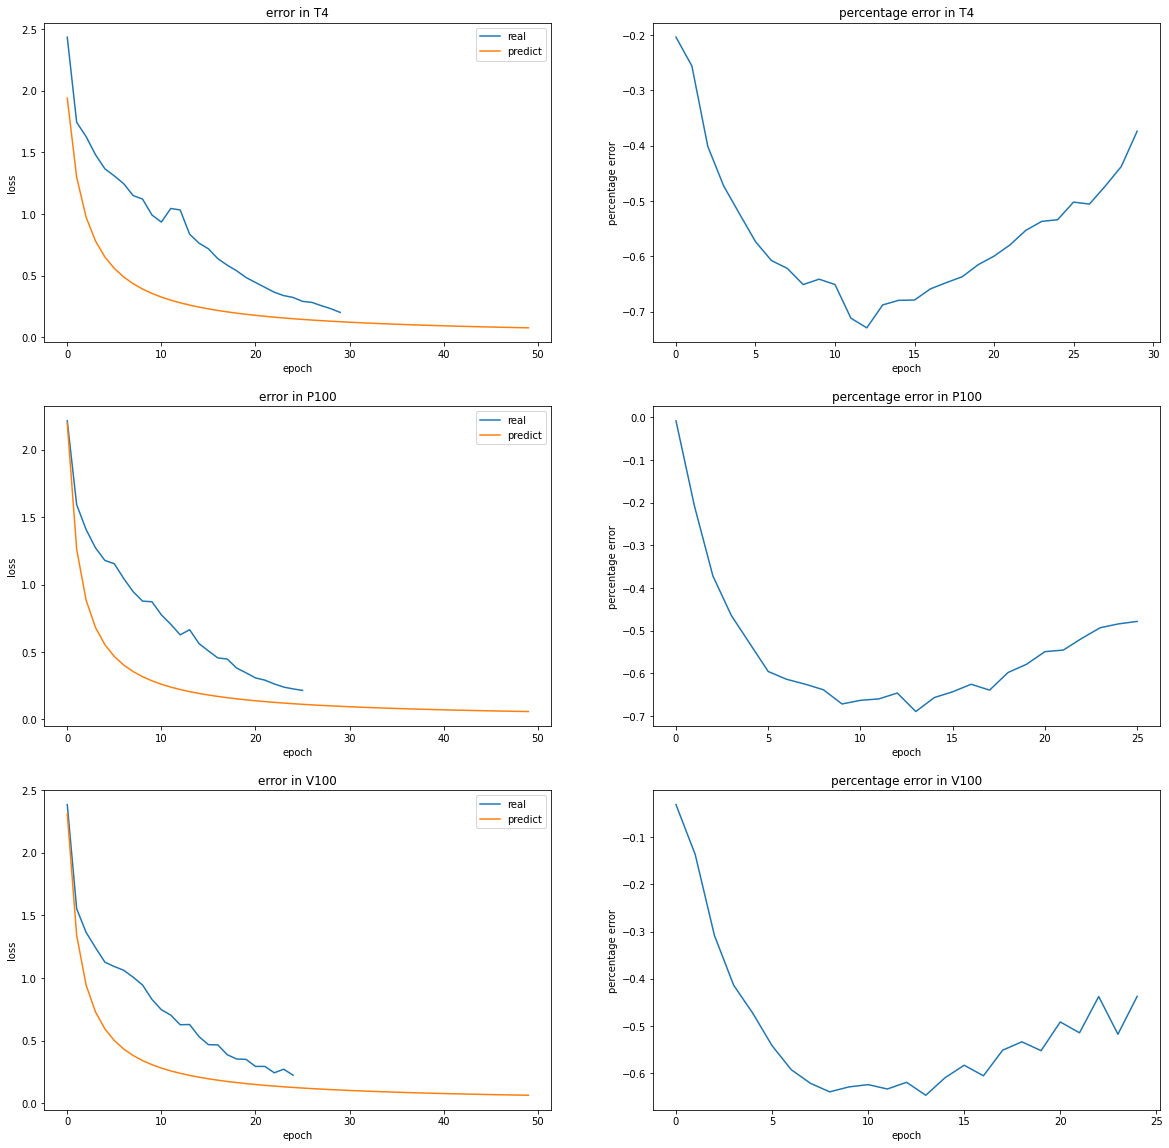

In [61]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
hardware = ['t4', 'p100', 'v100']

t4_res50 = pd.read_csv('./problem4/resnet-50_t4.csv')
t4_res50 = t4_res50.groupby(['epoch'])['training_step_loss'].mean().reset_index()
p100_res50 = pd.read_csv('./problem4/resnet-50_p100.csv')
p100_res50 = p100_res50.groupby(['epoch'])['training_step_loss'].mean().reset_index()
v100_res50 = pd.read_csv('./problem4/resnet-50_v100.csv')
v100_res50 = v100_res50.groupby(['epoch'])['training_step_loss'].mean().reset_index()

axs[0, 0].plot(t4_res50['epoch'], t4_res50['training_step_loss'], label='real')
axs[0, 0].plot(np.arange(len(t4_predction)), t4_predction, label='predict')
axs[0, 0].legend()
axs[0, 0].set_title('error in T4')
axs[0, 0].set(xlabel='epoch', ylabel='loss')

axs[1, 0].plot(p100_res50['epoch'], p100_res50['training_step_loss'], label='real')
axs[1, 0].plot(np.arange(len(p100_prediction)), p100_prediction, label='predict')
axs[1, 0].legend()
axs[1, 0].set_title('error in P100')
axs[1, 0].set(xlabel='epoch', ylabel='loss')

axs[2, 0].plot(v100_res50['epoch'], v100_res50['training_step_loss'], label='real')
axs[2, 0].plot(np.arange(len(v100_prediction)), v100_prediction, label='predict')
axs[2, 0].legend()
axs[2, 0].set_title('error in V100')
axs[2, 0].set(xlabel='epoch', ylabel='loss')

new_t4 = t4_predction[:len(t4_res50['epoch'])]
axs[0, 1].plot(t4_res50['epoch'], (new_t4 - t4_res50['training_step_loss']) / t4_res50['training_step_loss'])
axs[0, 1].set_title('percentage error in T4')
axs[0, 1].set(xlabel='epoch', ylabel='percentage error')   

new_p100 = p100_prediction[:len(p100_res50['epoch'])]
axs[1, 1].plot(p100_res50['epoch'], (new_p100 - p100_res50['training_step_loss']) / p100_res50['training_step_loss'])
axs[1, 1].set_title('percentage error in P100')
axs[1, 1].set(xlabel='epoch', ylabel='percentage error') 

new_v100 = v100_prediction[:len(v100_res50['epoch'])]
axs[2, 1].plot(v100_res50['epoch'], (new_v100 - v100_res50['training_step_loss']) / v100_res50['training_step_loss'])
axs[2, 1].set_title('percentage error in V100')
axs[2, 1].set(xlabel='epoch', ylabel='percentage error')

<p> 3. </p>

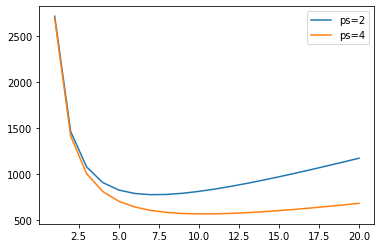

In [68]:
w = np.arange(1, 21)
M = 128
predict_epoch = 20

# based on the paper, theta0=1.02, theta1=2.78, theta2=4.92, theta3=0.00, theta4=0.02
# ps = 2
time2acc_2 = predict_epoch / (1 / (1.02 * M / w + 2.78 + 4.92 * w / 2 + 0.00 * w + 0.02 * 2))

# ps = 4
time2acc_4 = predict_epoch / (1 / (1.02 * M / w + 2.78 + 4.92 * w / 4 + 0.00 * w + 0.02 * 4))

plt.plot(w, time2acc_2, label='ps=2')
plt.plot(w, time2acc_4, label='ps=4')
plt.legend()
plt.show()